In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.getLogger("pgmpy").setLevel(logging.ERROR)

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, K2, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# -----------------------------
# Load Dataset
# -----------------------------
path = "."
file_name = "data_preprocessed.csv"
full_file_path = os.path.join(path, file_name)

data_set = pd.read_csv(full_file_path)

# -----------------------------
# Train-test split
# -----------------------------
target_column = "Osteoporosis"
X = data_set.drop(target_column, axis=1)
y = data_set[target_column]

train_df, test_df = train_test_split(data_set, test_size=0.3, random_state=42)

# -----------------------------
# Learn Bayesian Network Structure
# -----------------------------
print("Đang huấn luyện Bayesian Network structure...")
hc = HillClimbSearch(train_df)
best_model = hc.estimate(scoring_method=K2(train_df), max_indegree=2)
print("Hoàn thành huấn luyện Bayesian Network structure!\n")

model = DiscreteBayesianNetwork(best_model.edges())

# -----------------------------
# Fit CPDs using Maximum Likelihood Estimation
# -----------------------------
model.fit(train_df, estimator=MaximumLikelihoodEstimator)

# -----------------------------
# Perform inference
# -----------------------------
infer = VariableElimination(model)

# Only keep evidence variables that exist in the BN
bn_nodes = set(model.nodes())

y_pred = []
y_prob = []  # store predicted probability of class 1

for _, row in test_df.drop(columns=[target_column]).iterrows():
    evidence = {k: v for k, v in row.to_dict().items() if k in bn_nodes}
    factor = infer.query([target_column], evidence=evidence)

    prob_1 = factor.values[1]  # P(Osteoporosis=1)
    y_prob.append(prob_1)
    y_pred.append(1 if prob_1 >= 0.5 else 0)
y_true = test_df[target_column].values

edges = model.edges()
cpd_osteo = model.get_cpds("Osteoporosis")
report = classification_report(y_true, y_pred, target_names=['Osteoporosis = 0', 'Osteoporosis = 1'])
auc = roc_auc_score(y_true, y_prob)
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

In [3]:
# -----------------------------
# Thông số mô hình
# -----------------------------
print("=" * 60)
print("BAYESIAN BELIEF NETWORK CLASSIFIER")
print("=" * 60)
print("\n- Các cạnh trong network structure:")
for parent, child in edges:
    print(f"+ {parent} → {child}")
print("\nCPD của yếu tố Osteoporosis:")
print(cpd_osteo)

BAYESIAN BELIEF NETWORK CLASSIFIER

- Các cạnh trong network structure:
+ Age_Scaled → Osteoporosis
+ Race/Ethnicity_Asian → Race/Ethnicity_African American
+ Race/Ethnicity_Caucasian → Race/Ethnicity_African American
+ Race/Ethnicity_Caucasian → Race/Ethnicity_Asian
+ Medical Conditions_Rheumatoid Arthritis → Medical Conditions_Hyperthyroidism

CPD của yếu tố Osteoporosis:
+-----------------+---------------------------------+-----+------------------------------+
| Age_Scaled      | Age_Scaled(-0.9883443973130418) | ... | Age_Scaled(2.38402562291165) |
+-----------------+---------------------------------+-----+------------------------------+
| Osteoporosis(0) | 0.8849557522123894              | ... | 0.0                          |
+-----------------+---------------------------------+-----+------------------------------+
| Osteoporosis(1) | 0.11504424778761062             | ... | 1.0                          |
+-----------------+---------------------------------+-----+------------------


- Confusion matrix



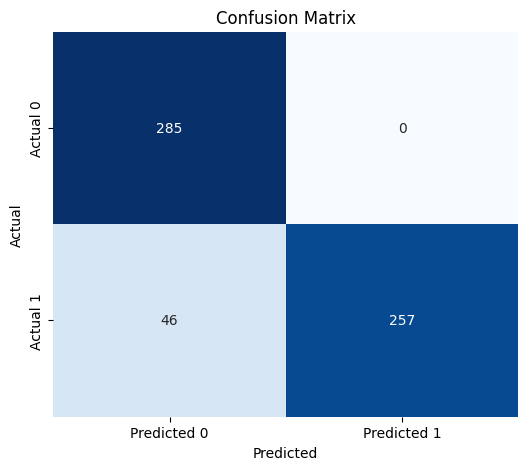

In [12]:
# -----------------------------
# Vẽ Confusion Matrix
# -----------------------------
print("\n- Confusion matrix\n")
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [10]:
# -----------------------------
# Kết quả mô hình
# -----------------------------
print("\n- Chi tiết confusion matrix:")
print(f"+ True Negative (TN):  {TN} - Dự đoán đúng 'Không có'")
print(f"+ False Positive (FP): {FP} - Dự đoán sai 'Có' (thực tế 'Không có')")
print(f"+ False Negative (FN): {FN} - Dự đoán sai 'Không có' (thực tế 'Có')")
print(f"+ True Positive (TP):   {TP} - Dự đoán đúng 'Có'")
print("\n- Classification report\n", report)
print(f"AUC-ROC:   {auc:.3f} ({auc*100:.0f}%)")


- Chi tiết confusion matrix:
+ True Negative (TN):  285 - Dự đoán đúng 'Không có'
+ False Positive (FP): 0 - Dự đoán sai 'Có' (thực tế 'Không có')
+ False Negative (FN): 46 - Dự đoán sai 'Không có' (thực tế 'Có')
+ True Positive (TP):   257 - Dự đoán đúng 'Có'

- Classification report
                   precision    recall  f1-score   support

Osteoporosis = 0       0.86      1.00      0.93       285
Osteoporosis = 1       1.00      0.85      0.92       303

        accuracy                           0.92       588
       macro avg       0.93      0.92      0.92       588
    weighted avg       0.93      0.92      0.92       588

AUC-ROC:   0.929 (93%)
